In [2]:
import random
import scipy.io as sio
import numpy as np
import pandas as pd

# 设置小区
districts = ['A', 'B', 'C', 'D', 'E', 'F']

# 加载 mat 文件
data = sio.loadmat('cluster_users_dict.mat')
print(data.keys())  # 打印 data 字典中的键
print(type(data['cluster_1']))

# 初始化每个小区的用户统计信息
district_user_counts = {district: 0 for district in districts}
district_user_compositions = {district: [] for district in districts}

# 定义用户类别及其权重
user_clusters = {
    'cluster_1': 0.25,
    'cluster_2': 0.25,
    'cluster_3': 0.25,
    'cluster_4': 0.25
}

# 确保数据保持整数形式
for cluster in user_clusters.keys():
    data[cluster] = data[cluster].flatten().astype(int)

# 创建用户ID到数据索引的映射
user_id_to_index = {user_id: idx for idx, user_id in enumerate(sorted(set(data['cluster_1']).union(set(data['cluster_2']), set(data['cluster_3']), set(data['cluster_4']))))}

# 小区用户组成，使用 random.choices 随机抽取用户
district_compositions = {
    'A': [501, 50, 70, 90],
    'B': [23, 209, 22, 219],
    'C': [0, 23, 0, 561],
    'D': [150, 500, 21, 37],
    'E': [14, 1, 64, 95],
    'F': [600, 200, 150, 50]
}

for district in districts:
    district_user_compositions[district] = []
    for i, cluster in enumerate(user_clusters.keys()):
        selected_users = random.choices(data[cluster], k=district_compositions[district][i])
        district_user_compositions[district].extend(selected_users)
    random.shuffle(district_user_compositions[district])

# 计算统计信息
for district in districts:
    district_user_counts[district] = len(district_user_compositions[district])

    print(f"小区 {district}:")
    print(f"  用户总数: {district_user_counts[district]}")
    
    # 计算每个类别的用户数量
    cluster_counts = {cluster: sum([1 for user in district_user_compositions[district] if user in data[cluster]]) for cluster in user_clusters}
    
    print(f"  用户类别组成:")
    for cluster, count in cluster_counts.items():
        print(f"    {cluster}: {count}")

# 加载用户负载数据
data_load = sio.loadmat('data.mat')

user_no = 0     # 指定用户（0-3636，一共3637名用户）
data_type = 1   # 0表示用户编号（没啥作用），1表示功率数据
print(data_load["customer"][0][user_no][data_type].shape)
    
# 创建一个空numpy数组
load = np.zeros((3637,24,171))
for user in range(3637):
    load[user] = np.array(data_load["customer"][0][user][data_type])
# 创建一个字典来存储每个小区的用户ID和对应的类别
district_user_info = {}

# 为每个小区创建用户信息
for district in districts:
    user_ids = district_user_compositions[district]
    user_clusters = []
    user_weekloads = []
    
    for user_id in user_ids:
        if user_id in data['cluster_1']:
            user_clusters.append('cluster_1')
        elif user_id in data['cluster_2']:
            user_clusters.append('cluster_2')
        elif user_id in data['cluster_3']:
            user_clusters.append('cluster_3')
        elif user_id in data['cluster_4']:
            user_clusters.append('cluster_4')
        else:
            user_clusters.append('unknown')  # 以防有未分类的用户
        
        # 添加weekload数据
        if user_id in user_id_to_index:
            user_index = user_id_to_index[user_id]
            user_weekloads.append(load[user_index].tolist())
        else:
            print(f"Warning: User ID {user_id} is not found in user_id_to_index mapping.")

    # 创建DataFrame
    df = pd.DataFrame({
        'user_id': user_ids,
        'cluster': user_clusters,
        'weekload': user_weekloads
    })
    
    # 将DataFrame存储到字典中
    district_user_info[district] = df

# 打印每个小区的用户信息
for district, df in district_user_info.items():
    print(f"\n小区 {district} 的用户信息:")
    print(df.head())  # 只打印前5行作为示例
    print(f"总用户数: {len(df)}")

# 创建一个新的字典来存储要保存到mat文件中的数据
mat_data = {}

for district, df in district_user_info.items():
    # 将DataFrame转换为numpy数组
    user_data = df.to_numpy()
    
    # 将numpy数组存储到mat_data字典中
    mat_data[f'{district}_user_data'] = user_data

# 保存mat文件
sio.savemat('district_user_info.mat', mat_data)

print("数据已保存到 district_user_info.mat 文件中")
import pandas as pd
import numpy as np
import scipy.io as sio

# 合并小区 A-E 的用户信息到新小区 G
g_user_ids = []
g_user_clusters = []
g_user_weekloads = []

for district in ['A', 'B', 'C', 'D', 'E']:
    g_user_ids.extend(district_user_info[district]['user_id'].tolist())
    g_user_clusters.extend(district_user_info[district]['cluster'].tolist())
    g_user_weekloads.extend(district_user_info[district]['weekload'].tolist())

# 创建新小区 G 的 DataFrame
g_df = pd.DataFrame({
    'user_id': g_user_ids,
    'cluster': g_user_clusters,
    'weekload': g_user_weekloads
})

# 将新小区 G 的 DataFrame 添加到 district_user_info 字典中
district_user_info['G'] = g_df

# 更新 mat_data 字典
mat_data['G_user_data'] = g_df.to_numpy()

# 保存更新后的 mat 文件
sio.savemat('district_user_info.mat', mat_data)

print("已将小区 A-E 的用户合并到新小区 G，并保存到 district_user_info.mat 文件中")

dict_keys(['__header__', '__version__', '__globals__', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4'])
<class 'numpy.ndarray'>
小区 A:
  用户总数: 711
  用户类别组成:
    cluster_1: 501
    cluster_2: 50
    cluster_3: 70
    cluster_4: 90
小区 B:
  用户总数: 473
  用户类别组成:
    cluster_1: 23
    cluster_2: 209
    cluster_3: 22
    cluster_4: 219
小区 C:
  用户总数: 584
  用户类别组成:
    cluster_1: 0
    cluster_2: 23
    cluster_3: 0
    cluster_4: 561
小区 D:
  用户总数: 708
  用户类别组成:
    cluster_1: 150
    cluster_2: 500
    cluster_3: 21
    cluster_4: 37
小区 E:
  用户总数: 174
  用户类别组成:
    cluster_1: 14
    cluster_2: 1
    cluster_3: 64
    cluster_4: 95
小区 F:
  用户总数: 1000
  用户类别组成:
    cluster_1: 600
    cluster_2: 200
    cluster_3: 150
    cluster_4: 50


C:\Users\29623\AppData\Local\Temp\ipykernel_12124\1473687738.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data[cluster] = data[cluster].flatten().astype(int)


(24, 171)

小区 A 的用户信息:
   user_id    cluster                                           weekload
0     3448  cluster_1  [[0.9039999999999999, 0.437, 0.477500000000000...
1     5718  cluster_3  [[0.14400000000000002, 1.082, 0.1515, 0.2785, ...
2     7281  cluster_1  [[1.8435, 0.6315, 0.797, 1.214, 1.1515, 0.4755...
3     1590  cluster_1  [[0.5785, 0.5035000000000001, 0.6725, 1.157500...
4     6434  cluster_1  [[0.591, 1.218, 0.5914999999999999, 1.9485, 2....
总用户数: 711

小区 B 的用户信息:
   user_id    cluster                                           weekload
0     2367  cluster_2  [[0.046, 0.082, 0.0665, 0.0415, 0.109, 0.07450...
1     6848  cluster_2  [[1.208, 1.7360000000000002, 0.62, 1.252, 0.37...
2     2196  cluster_4  [[0.13, 0.026, 0.055999999999999994, 0.0375, 0...
3     3336  cluster_2  [[0.215, 0.191, 0.2, 0.1895, 0.248, 0.4275, 0....
4     3246  cluster_1  [[0.087, 0.077, 0.1845, 0.077, 0.0735000000000...
总用户数: 473

小区 C 的用户信息:
   user_id    cluster                                  

In [9]:
import random
import scipy.io as sio
import numpy as np

# 加载 mat 文件
data = sio.loadmat('cluster_users_dict.mat')

# 确保数据保持整数形式
for cluster in ['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4']:
    data[cluster] = data[cluster].flatten().astype(int)

# 创建用户ID到数据索引的映射
user_id_to_index = {user_id: idx for idx, user_id in enumerate(sorted(set(data['cluster_1']).union(set(data['cluster_2']), set(data['cluster_3']), set(data['cluster_4']))))}

# 打印映射的完整性
print("用户ID到数据索引的映射长度:", len(user_id_to_index))

# 打印部分映射进行手动检查
sample_size = 10  # 随机抽取10个样本进行检查
sample_user_ids = random.sample(list(user_id_to_index.keys()), sample_size)
print("部分用户ID到数据索引的映射样本:")
for user_id in sample_user_ids:
    print(f"用户ID: {user_id} -> 数据索引: {user_id_to_index[user_id]}")

# 加载用户负载数据
data_load = sio.loadmat('data.mat')
data_type = 1  # 1表示功率数据

# 创建一个空numpy数组
load = np.zeros((3637, 24, 171))

for user in range(3637):
    load[user] = np.array(data_load["customer"][0][user][data_type])

# 验证一些用户的数据一致性
consistency_checks = 5  # 随机抽取5个用户进行一致性检查
check_user_ids = random.sample(list(user_id_to_index.keys()), consistency_checks)
print("验证数据一致性的用户ID和索引:")
for user_id in check_user_ids:
    user_index = user_id_to_index[user_id]
    original_data = load[user_index]
    # 通过映射索引访问的数据
    mapped_data = np.array(data_load["customer"][0][user_index][data_type])
    print(f"用户ID: {user_id}, 数据索引: {user_index}")
    if np.array_equal(original_data, mapped_data):
        print("  数据一致")
    else:
        print("  数据不一致")


用户ID到数据索引的映射长度: 3637
部分用户ID到数据索引的映射样本:
用户ID: 4290 -> 数据索引: 1850
用户ID: 4697 -> 数据索引: 2074
用户ID: 5499 -> 数据索引: 2529
用户ID: 2099 -> 数据索引: 616
用户ID: 3019 -> 数据索引: 1146
用户ID: 4818 -> 数据索引: 2143
用户ID: 5178 -> 数据索引: 2351
用户ID: 1212 -> 数据索引: 113
用户ID: 4952 -> 数据索引: 2223
用户ID: 5425 -> 数据索引: 2483


C:\Users\29623\AppData\Local\Temp\ipykernel_9764\528956352.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data[cluster] = data[cluster].flatten().astype(int)


验证数据一致性的用户ID和索引:
用户ID: 6054, 数据索引: 2852
  数据一致
用户ID: 6219, 数据索引: 2941
  数据一致
用户ID: 3837, 数据索引: 1612
  数据一致
用户ID: 7031, 数据索引: 3406
  数据一致
用户ID: 5668, 数据索引: 2630
  数据一致


In [44]:
import numpy as np
import scipy.io as sio
import pandas as pd
from vmdpy import VMD

def preprocess_data(file_path, districts):
    # 加载数据
    mat_data = sio.loadmat(file_path)
    
    processed_data = {}
    
    for district in districts:
        key = f'{district}_user_data'
        if key not in mat_data:
            print(f"警告: 未找到{district}小区的数据")
            continue
        
        data = mat_data[key]
        if data.shape[1] <= 2:
            print(f"警告: {district}小区的数据格式不正确")
            continue
        
        # 提取weekload数据
        weekload_data = []
        for row in data:
            if isinstance(row[2], (list, np.ndarray)) and len(row[2]) > 0:
                weekload = row[2]
                # 确保weekload是一维数组
                if isinstance(weekload, np.ndarray) and weekload.ndim > 1:
                    weekload = weekload.flatten()
                weekload_data.append(weekload)
        
        if not weekload_data:
            print(f"警告: {district}小区的weekload数据为空")
            continue
        
        # 将不同长度的时间序列填充到最大长度
        max_length = max(len(w) for w in weekload_data)
        padded_data = [np.pad(w, (0, max_length - len(w)), 'constant', constant_values=np.nan) for w in weekload_data]
        
        # 转换为numpy数组
        district_data = np.array(padded_data)
        
        # 处理缺失值（这里使用前向填充，您可以根据需要修改）
        district_data = pd.DataFrame(district_data).fillna(method='ffill').fillna(method='bfill').values
        
        # 计算平均weekload
        mean_weekload = np.mean(district_data, axis=0)
        
        if len(mean_weekload) == 0:
            print(f"警告: {district}小区的平均weekload长度为零")
            continue
        
        processed_data[district] = mean_weekload
    
    return processed_data

# 使用示例
file_path = 'district_user_info.mat'
districts = ['A', 'B', 'C', 'D', 'E', 'F']
processed_data = preprocess_data(file_path, districts)

# 定义VMD函数的参数
alpha = 2000  # 设置alpha参数
tau = 0  # 设置tau参数
K = 4  # 设置K参数
DC = 0  # 设置DC参数
init = 1  # 设置init参数
tol = 1e-6  # 设置tol参数

# 检查处理后的数据
for district, data in processed_data.items():
    print(f"{district}小区数据长度: {len(data)}")

# 使用vmdpy进行VMD分解
def perform_vmd(signal, alpha, tau, K, DC, init, tol):
    if len(signal) == 0:
        raise ValueError("信号长度为零")
    # 如果信号长度为1，复制信号以避免错误
    if len(signal) == 1:
        signal = np.repeat(signal, 2)
    u, u_hat, omega = VMD(signal, alpha, tau, K, DC, init, tol)
    return u, u_hat, omega

# 对每个小区进行VMD分解
vmd_results = {}
for district, signal in processed_data.items():
    try:
        u, u_hat, omega = perform_vmd(signal, alpha, tau, K, DC, init, tol)
        vmd_results[district] = (u, u_hat, omega)
        print(f"成功对{district}小区进行VMD分解")
    except Exception as e:
        print(f"对{district}小区进行VMD分解时出错: {str(e)}")

C:\Users\29623\AppData\Local\Temp\ipykernel_9764\659750483.py:45: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  district_data = pd.DataFrame(district_data).fillna(method='ffill').fillna(method='bfill').values


A小区数据长度: 4104
B小区数据长度: 4104
C小区数据长度: 4104
D小区数据长度: 4104
E小区数据长度: 4104
F小区数据长度: 4104
成功对A小区进行VMD分解
成功对B小区进行VMD分解
成功对C小区进行VMD分解
成功对D小区进行VMD分解
成功对E小区进行VMD分解
成功对F小区进行VMD分解


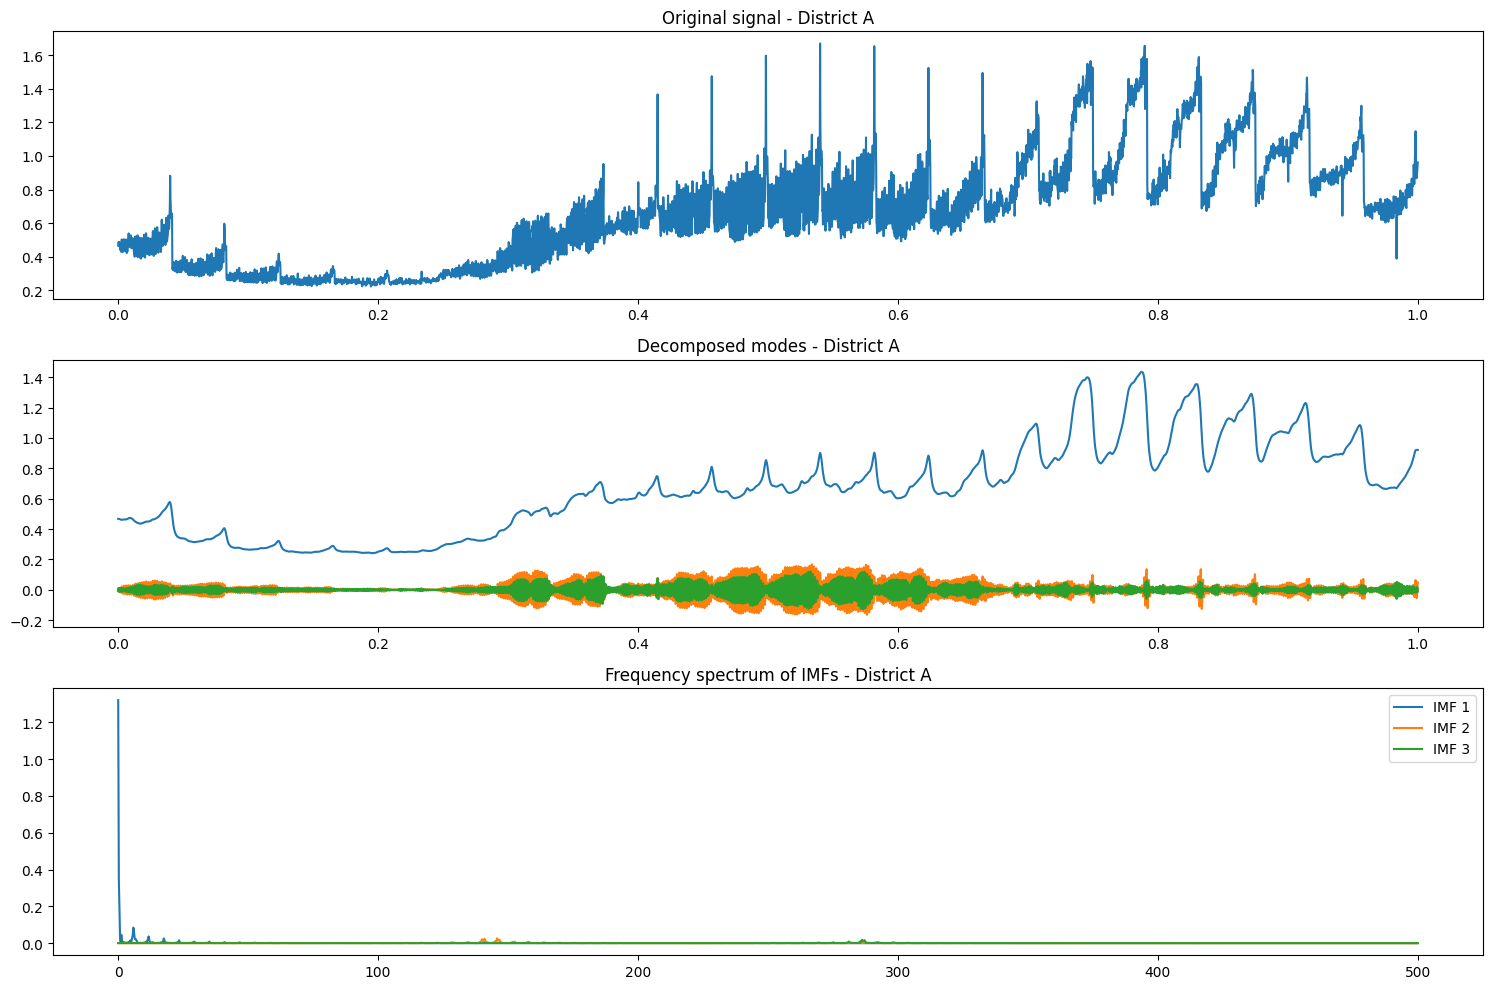

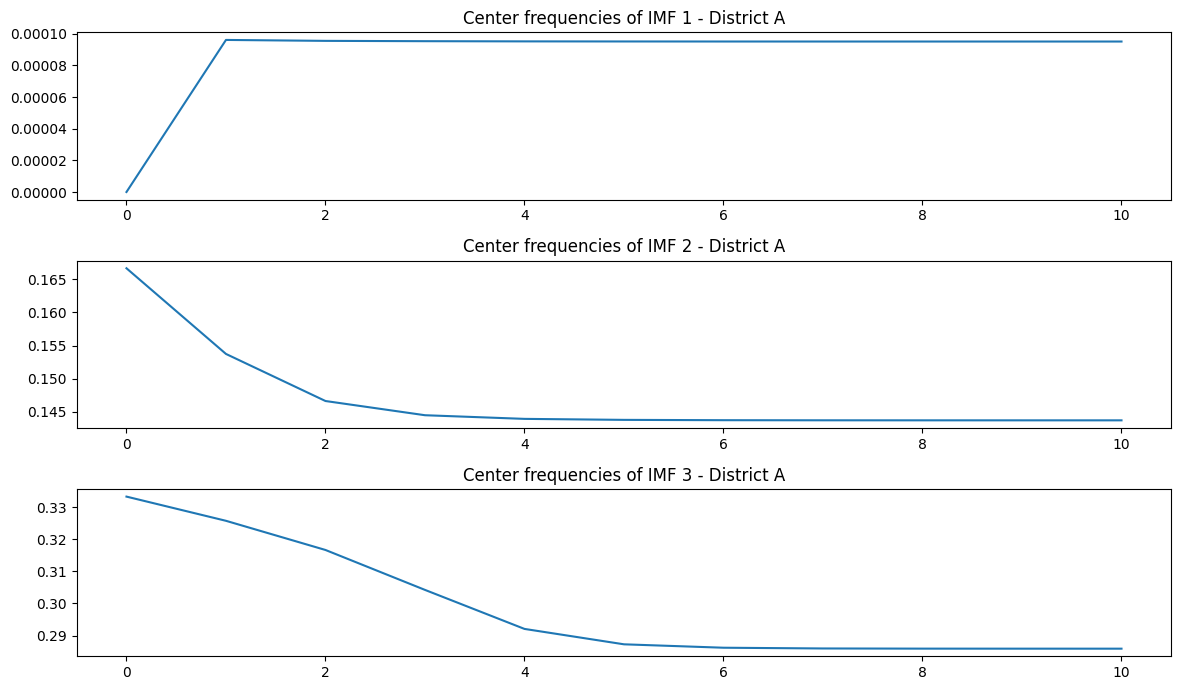

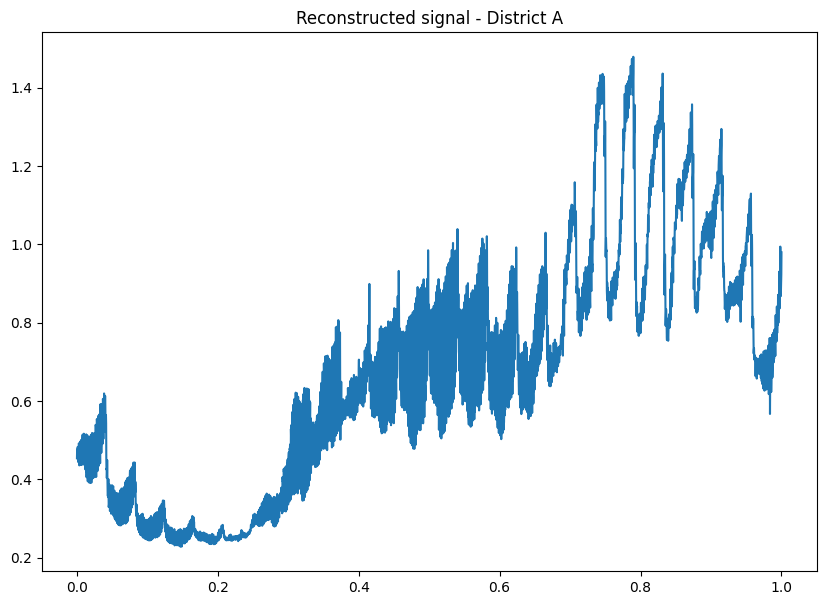

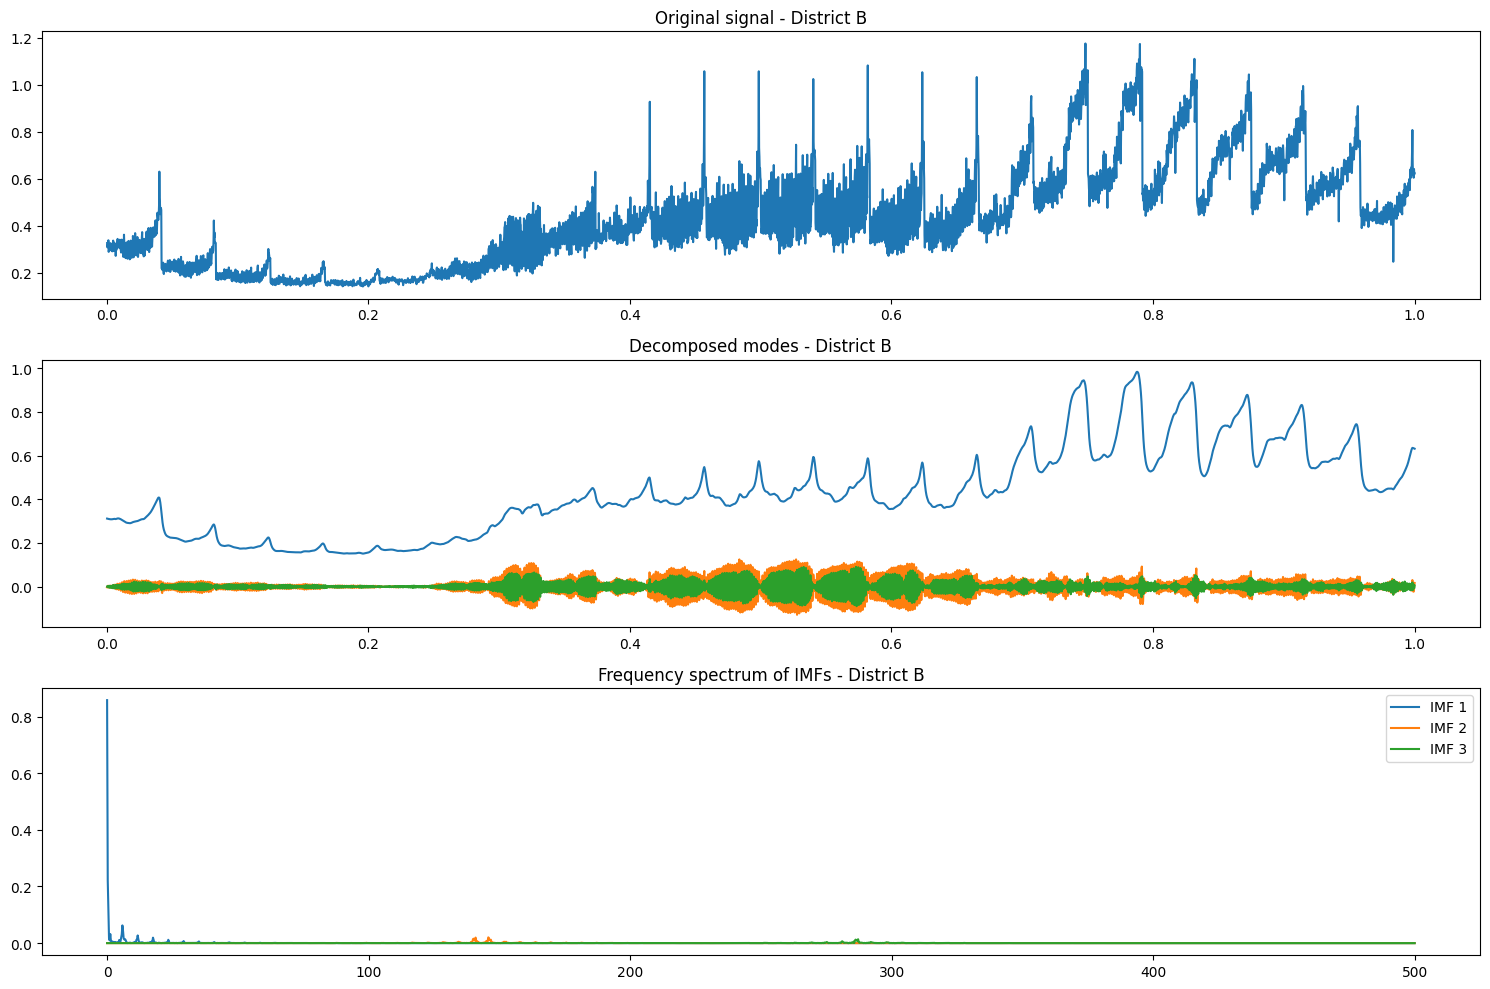

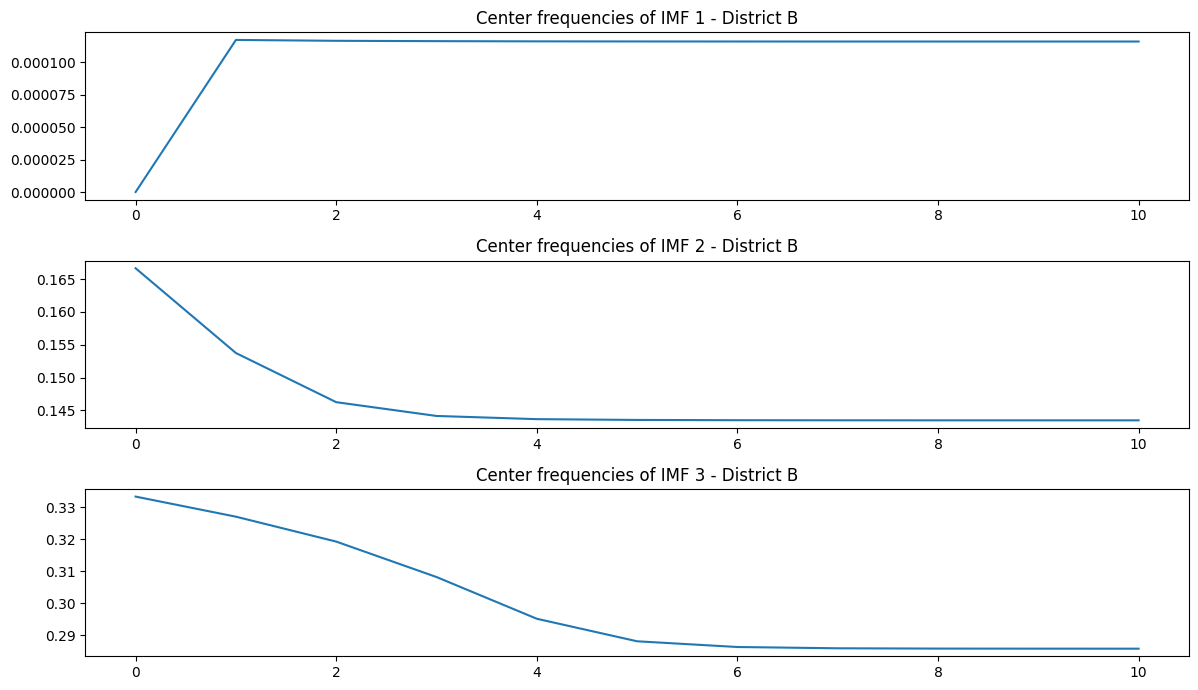

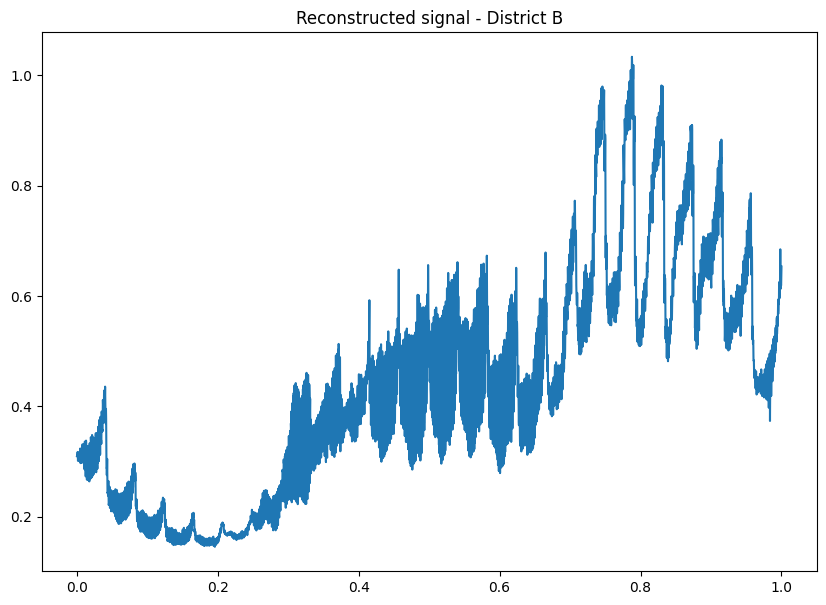

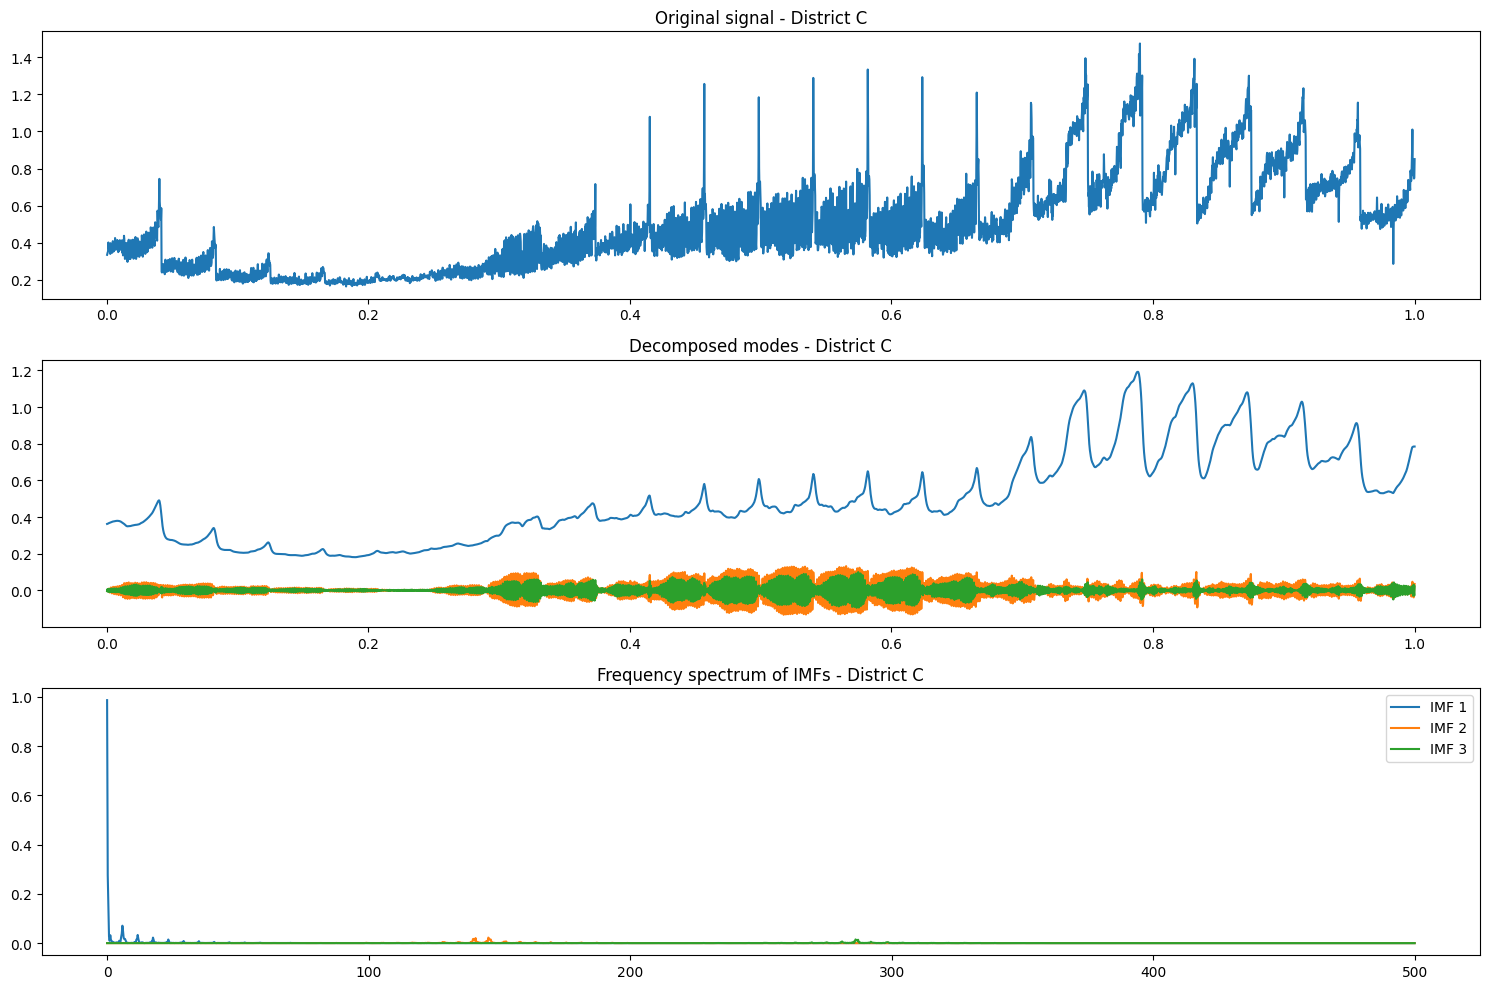

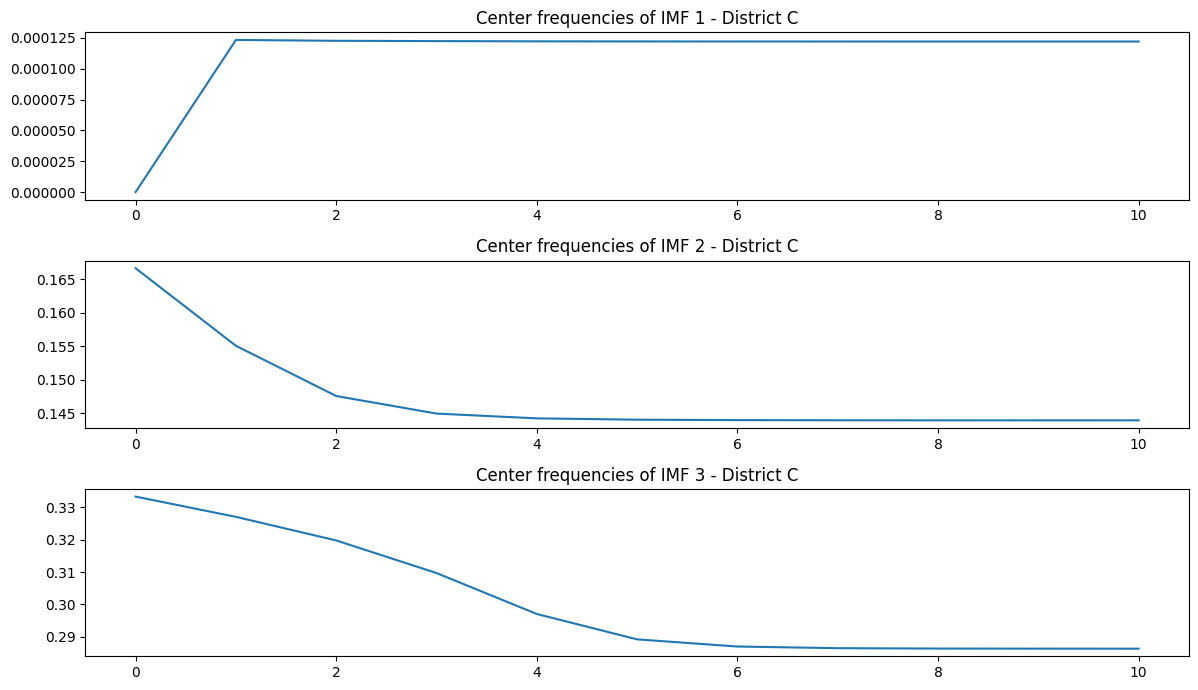

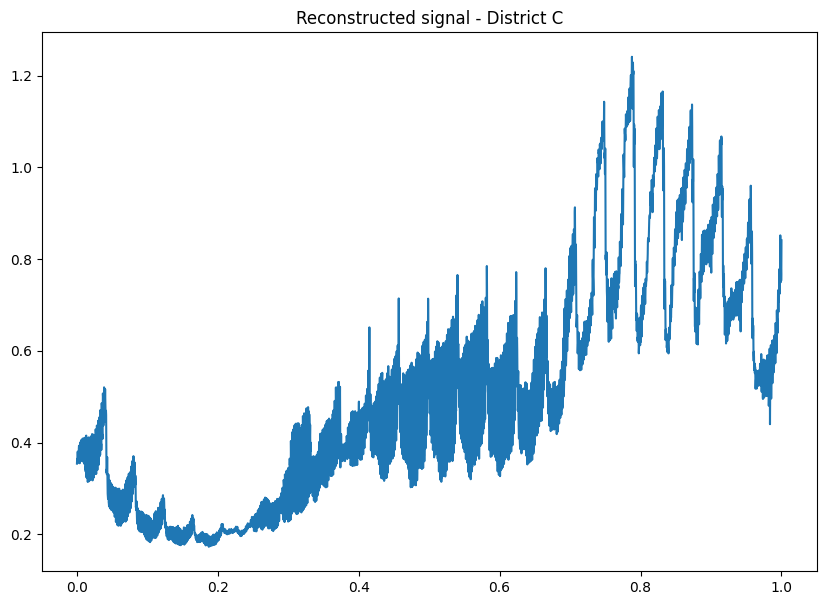

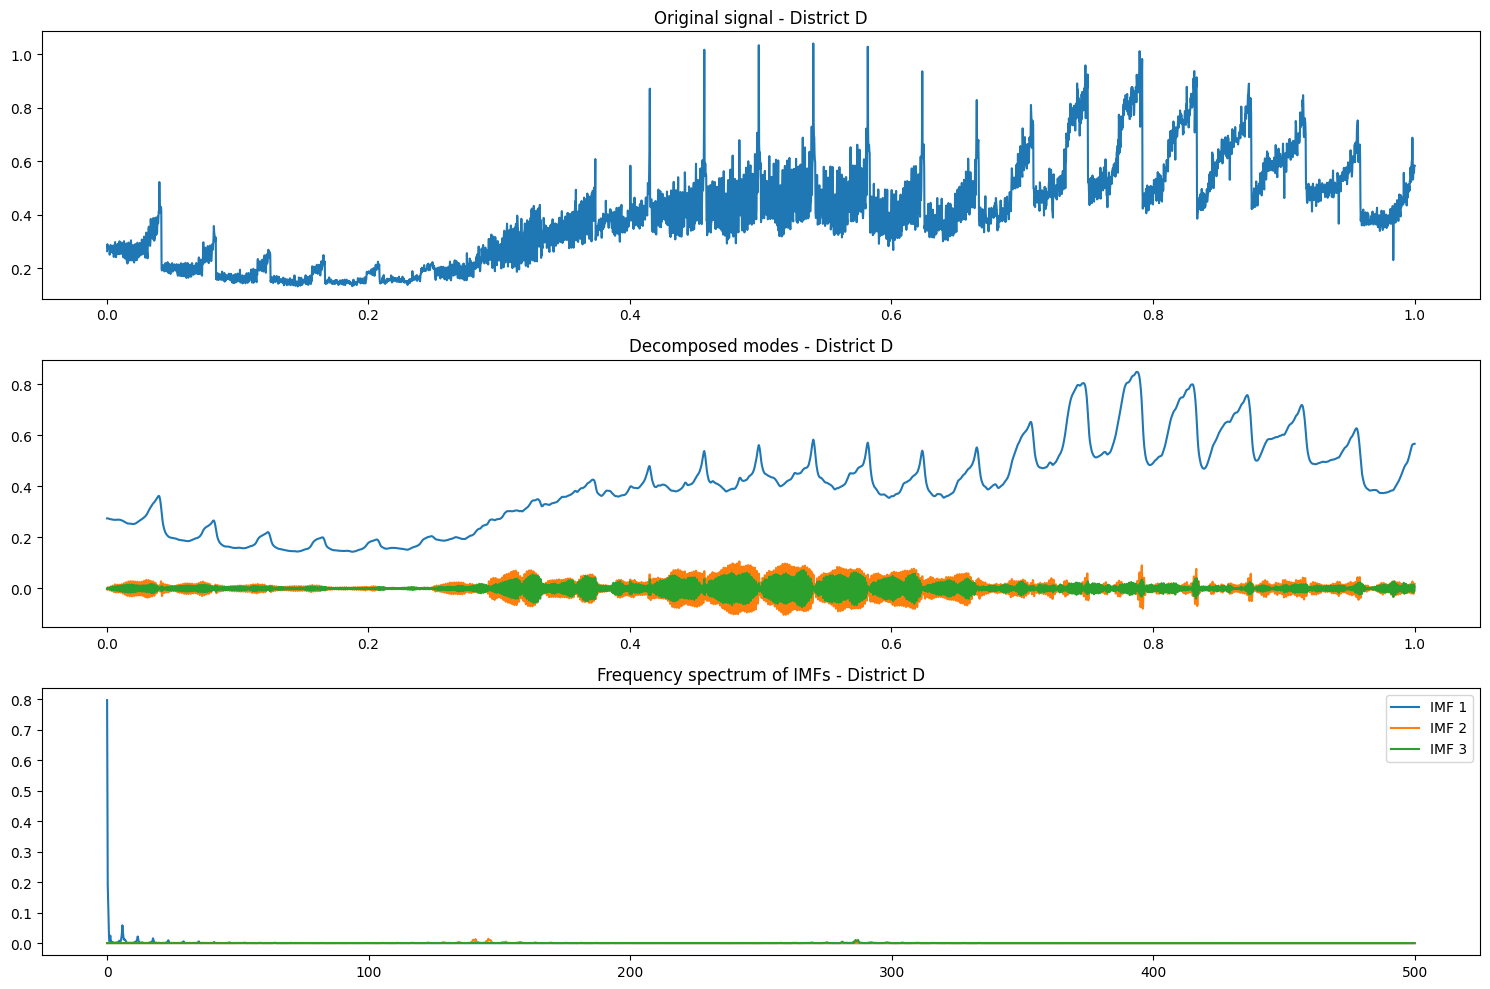

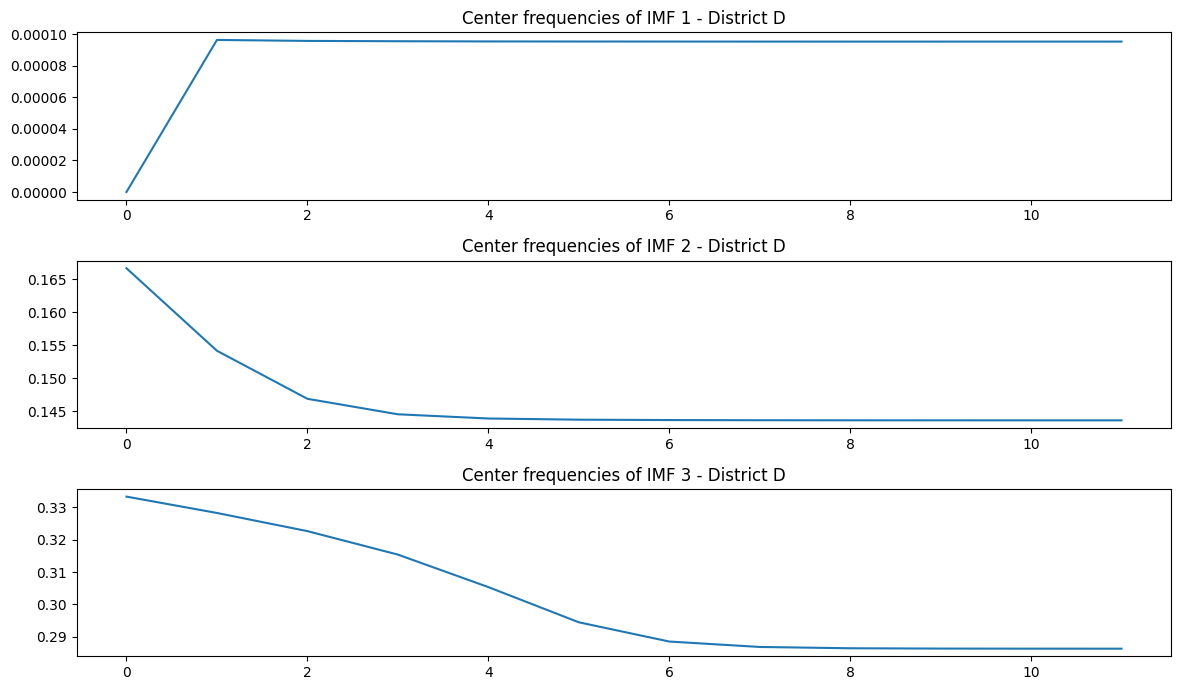

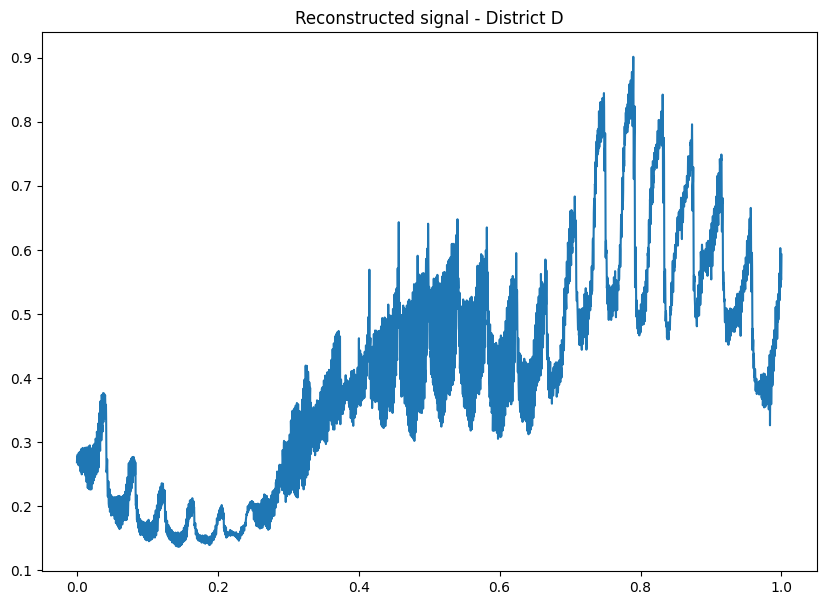

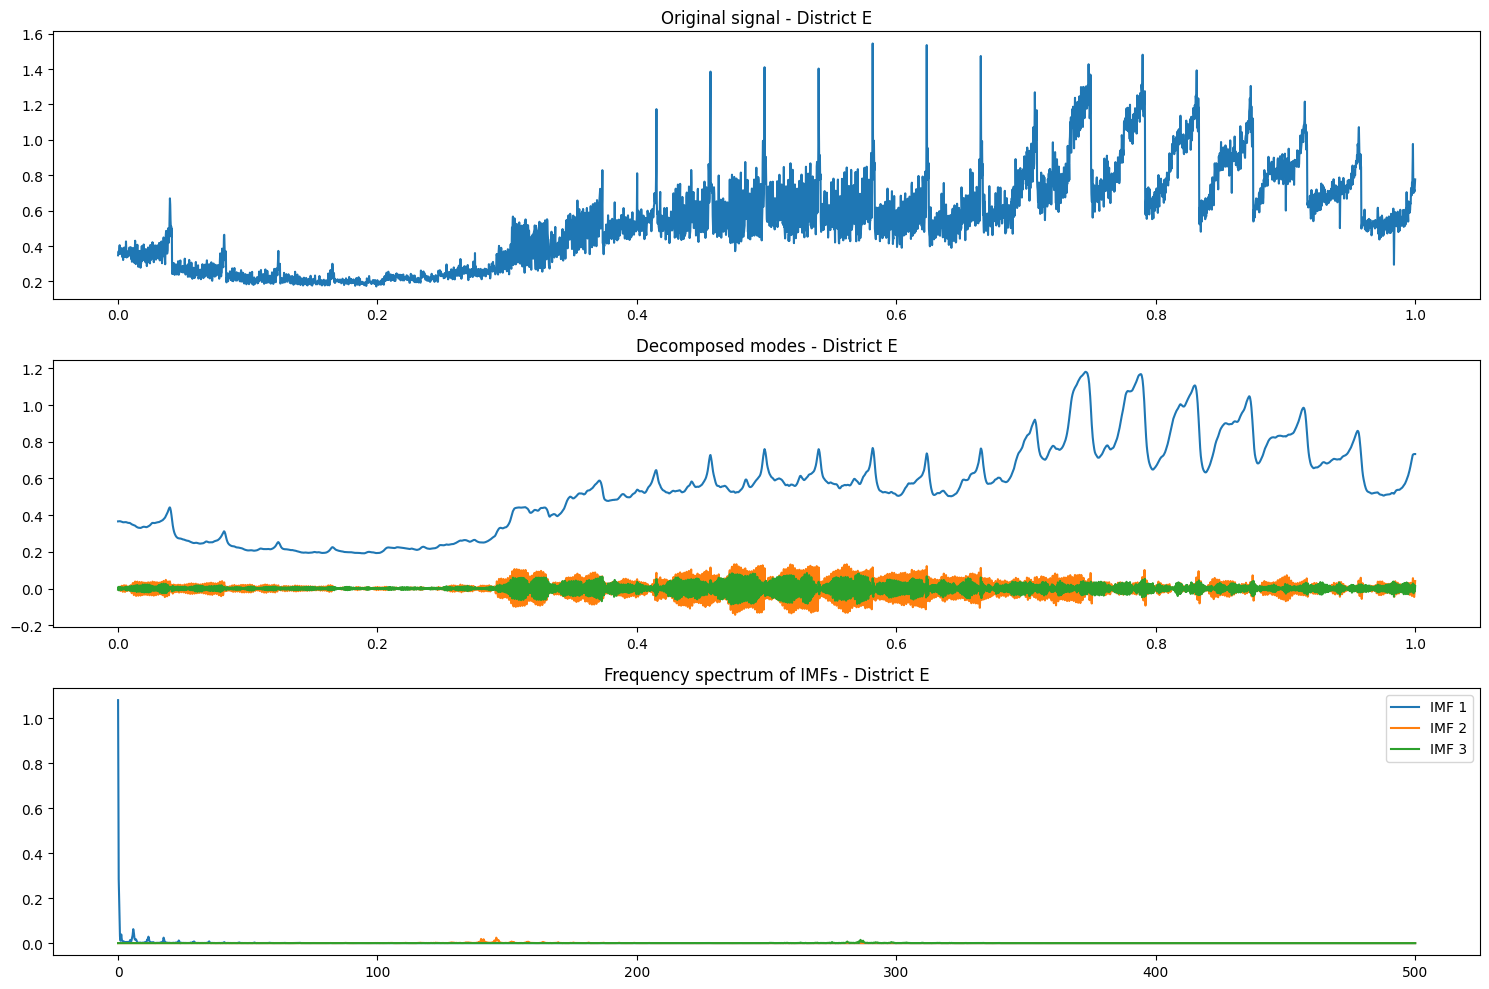

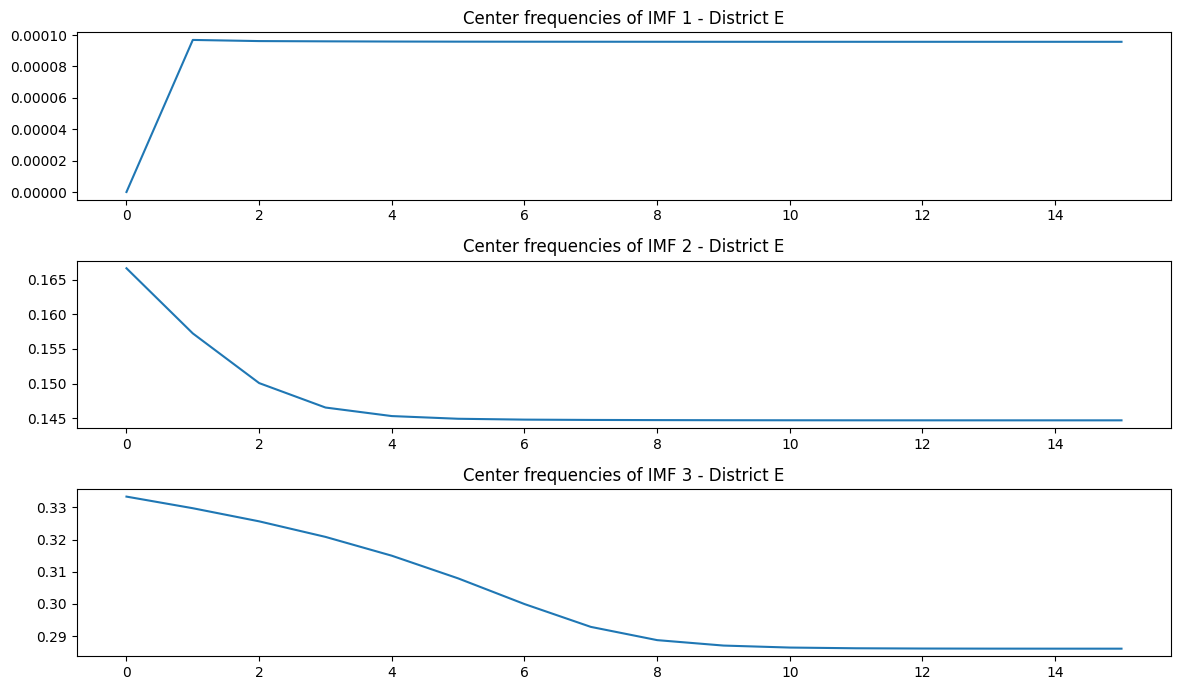

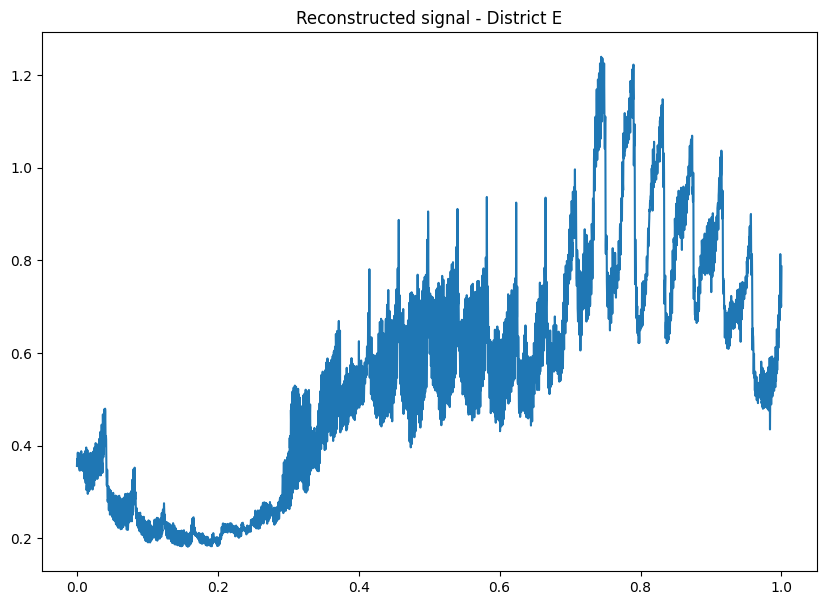

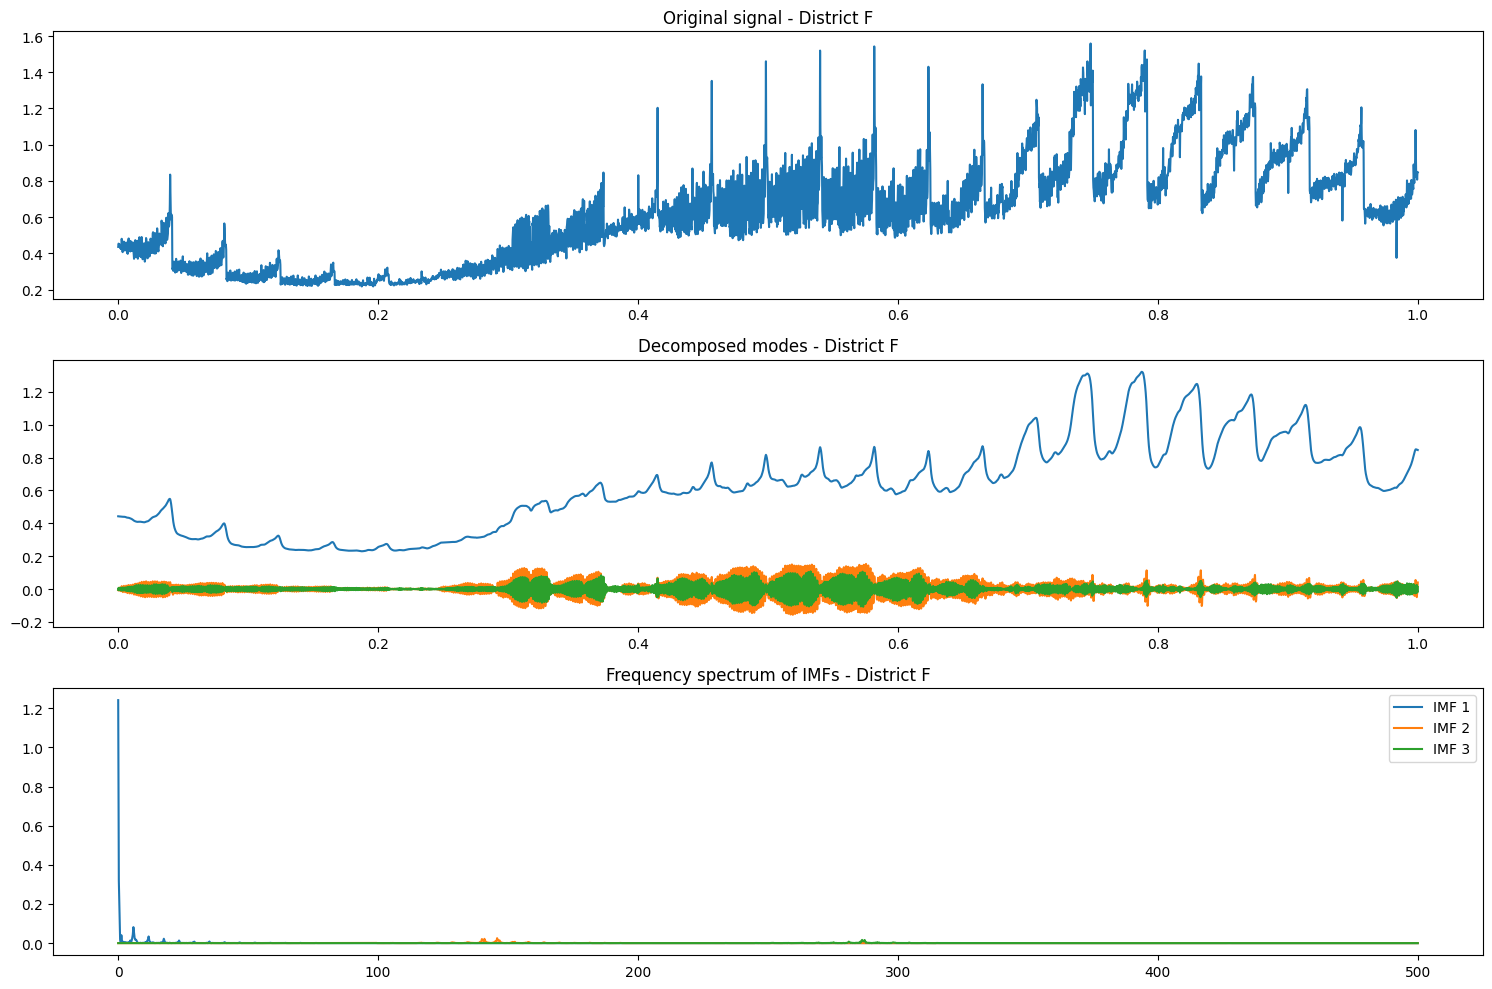

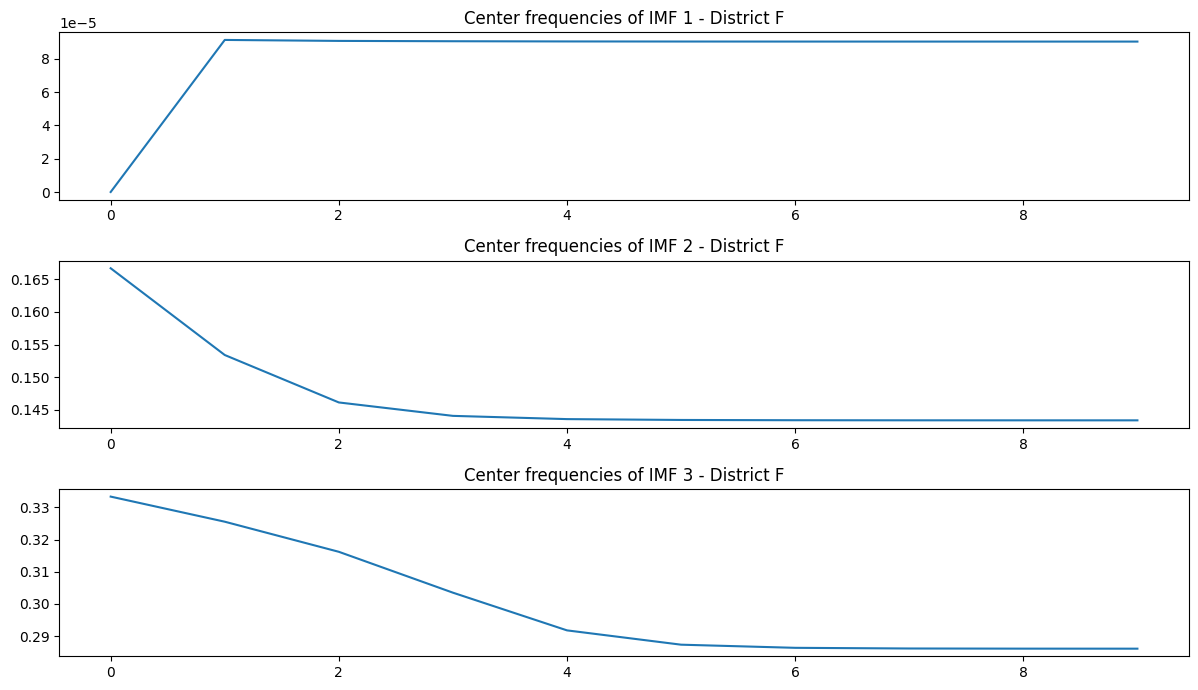

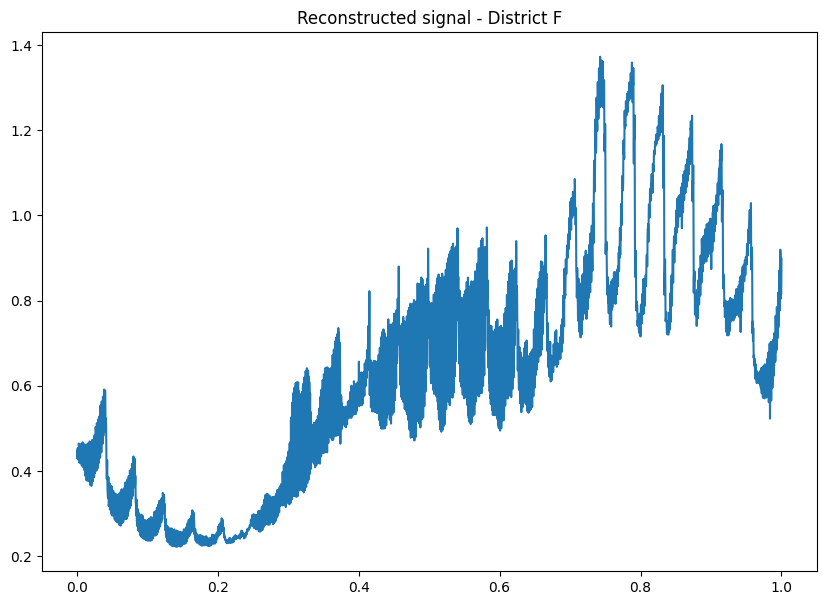

In [32]:
import numpy as np
from scipy.stats import pearsonr
from scipy.spatial.distance import cosine
from dtaidistance import dtw
import matplotlib.pyplot as plt

def extract_features(u, u_hat, omega):
    """从VMD结果中提取特征"""
    return {
        'imfs': u,
        'center_frequencies': np.mean(omega, axis=0),
        'energy': np.sum(u**2, axis=1),
        'bandwidth': np.std(omega, axis=0),
        'frequency_spectrum': np.mean(abs(u_hat), axis=0)
    }
    
def normalize_feature(feature):
    """归一化特征到 [0, 1] 范围"""
    min_val = np.min(feature)
    max_val = np.max(feature)
    if max_val == min_val:
        return np.zeros_like(feature)
    return (feature - min_val) / (max_val - min_val)

# 存储所有小区的特征
district_features = {}

# 使用现有的apply_vmd_and_plot函数，但添加特征提取
def apply_vmd_and_extract_features(signal, district_name, Fs=1000):
    N = len(signal)
    t = np.arange(1, N+1) / N
    fre_axis = np.linspace(0, Fs/2, int(N/2))

    # VMD parameters
    alpha = 2000
    tau = 0
    K = 3
    DC = 0
    init = 1
    tol = 1e-7

    # Apply VMD
    u, u_hat, omega = VMD(signal, alpha, tau, K, DC, init, tol)
    
    # Extract features
    features = extract_features(u, u_hat, omega)
    
    # Store features
    district_features[district_name] = features
    
    # Plot results
    plt.figure(figsize=(15, 10))

    # 1. Original signal
    plt.subplot(3, 1, 1)
    plt.plot(t, signal)
    plt.title(f'Original signal - District {district_name}')

    # 2. Decomposed IMFs
    plt.subplot(3, 1, 2)
    plt.plot(t, u.T)
    plt.title(f'Decomposed modes - District {district_name}')

    # 3. Frequency spectrum of IMFs
    plt.subplot(3, 1, 3)
    for i in range(K):
        plt.plot(fre_axis, abs(u_hat[:, i][int(N/2):])/(N/2), label=f'IMF {i+1}')
    plt.title(f'Frequency spectrum of IMFs - District {district_name}')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # 4. Center frequencies of IMFs
    plt.figure(figsize=(12, 7))
    for i in range(K):
        plt.subplot(K, 1, i + 1)
        plt.plot(omega[:, i])
        plt.title(f'Center frequencies of IMF {i+1} - District {district_name}')
    plt.tight_layout()
    plt.show()

    # 5. Reconstructed signal
    plt.figure(figsize=(10, 7))
    plt.plot(t, np.sum(u, axis=0))
    plt.title(f'Reconstructed signal - District {district_name}')
    plt.show()

# 应用VMD并提取特征
for district, signal in processed_data.items():
    apply_vmd_and_extract_features(signal, district)
    


Number of features: 24696
Number of center_frequencies features: 18
Number of energy features: 18
Number of bandwidth features: 18
Number of frequency_spectrum features: 18
Number of imf features: 24624
Average importance of center_frequencies: 0.000000
Average importance of energy: 0.000000
Average importance of bandwidth: 0.000000
Average importance of frequency_spectrum: 0.000000
Average importance of imf: 0.000244


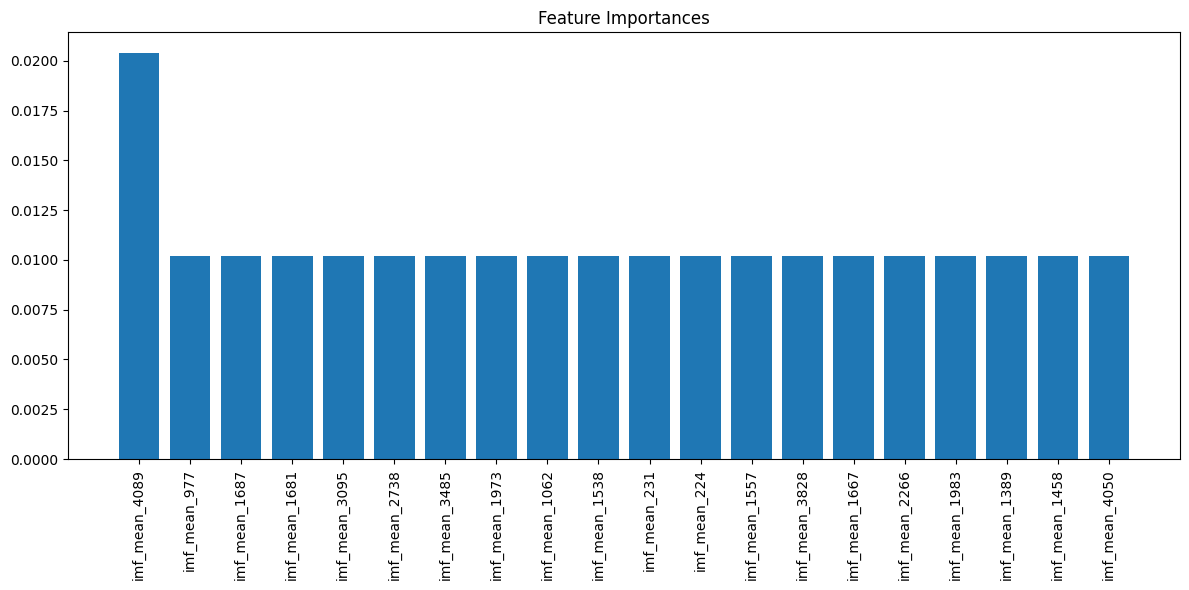

Adjusted weights based on feature importance:
center_frequencies: 0.0081
energy: 0.0081
bandwidth: 0.0081
frequency_spectrum: 0.0081
imfs: 0.8065
load_curve: 0.1613
F load curve shape: (1000, 24, 171)
A load curve shape: (711, 24, 171)
Load curve 1 shape: (711, 24, 171)
Load curve 2 shape: (1000, 24, 171)


Exception in thread Thread-9 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\29623\anaconda3\envs\torch\Lib\threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "c:\Users\29623\anaconda3\envs\torch\Lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\29623\anaconda3\envs\torch\Lib\threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\29623\anaconda3\envs\torch\Lib\subprocess.py", line 1597, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "<frozen codecs>", line 322, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb1 in position 29: invalid start byte
c:\Users\29623\anaconda3\envs\torch\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
'NoneType' object has no attribute 'splitlines'
Returning the number of

B load curve shape: (473, 24, 171)
Load curve 1 shape: (473, 24, 171)
Load curve 2 shape: (1000, 24, 171)


c:\Users\29623\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\29623\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


C load curve shape: (584, 24, 171)
Load curve 1 shape: (584, 24, 171)
Load curve 2 shape: (1000, 24, 171)


c:\Users\29623\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\29623\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


D load curve shape: (708, 24, 171)
Load curve 1 shape: (708, 24, 171)
Load curve 2 shape: (1000, 24, 171)
E load curve shape: (174, 24, 171)
Load curve 1 shape: (174, 24, 171)
Load curve 2 shape: (1000, 24, 171)


c:\Users\29623\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\29623\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\29623\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\29623\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMe


Updated similarities using adjusted weights:
A: 0.9624
B: 0.9502
C: 0.9171
D: 0.9159
E: 0.9162
与F小区最相似的小区是: A
各小区与F小区的相似度:
A: 0.9624
B: 0.9502
C: 0.9171
D: 0.9159
E: 0.9162


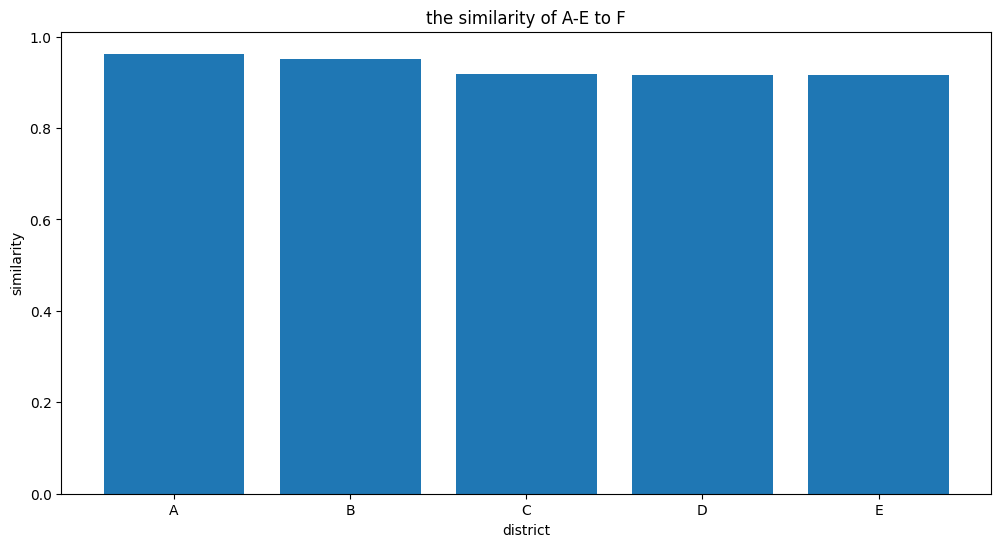

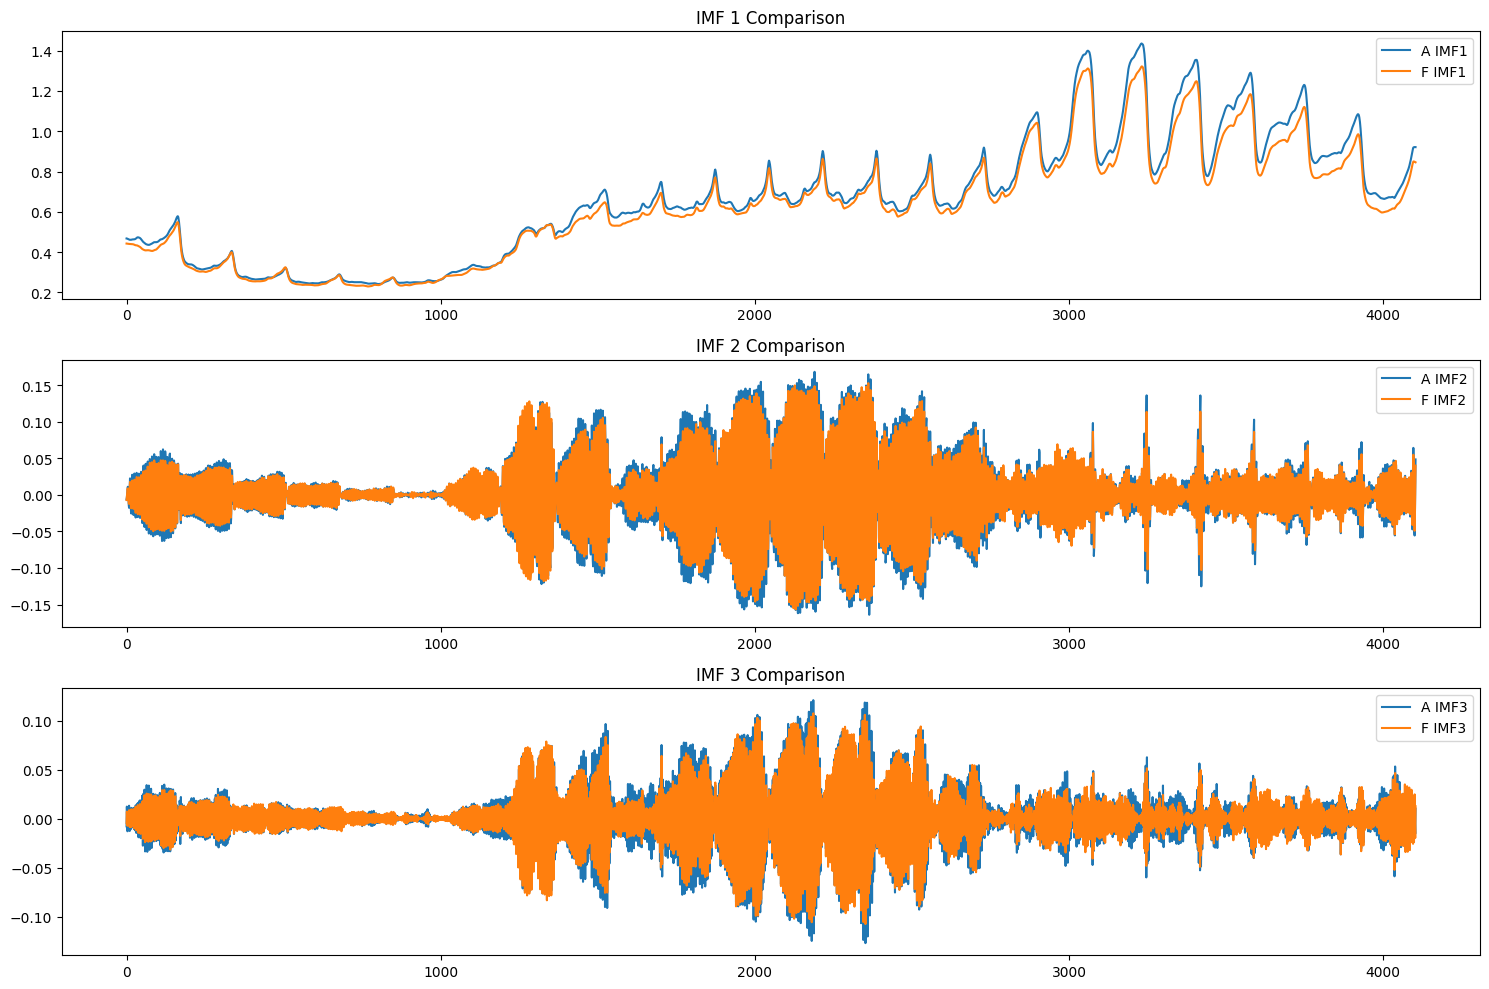

In [41]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.cluster import KMeans

def calculate_similarity(features1, features2, load_curve1, load_curve2, weights=None):
    if weights is None:
        weights = {
            'center_frequencies': 0.15,
            'energy': 0.15,
            'bandwidth': 0.1,
            'frequency_spectrum': 0.15,
            'imfs': 0.1,
            'load_curve': 0.35
        }
    
    similarity = 0
    
    # 打印负载曲线的形状
    print(f"Load curve 1 shape: {load_curve1.shape}")
    print(f"Load curve 2 shape: {load_curve2.shape}")
    
    # 使用余弦相似度来计算特征的相似性
    for feature_name in ['center_frequencies', 'energy', 'bandwidth', 'frequency_spectrum']:
        vec1 = features1[feature_name].flatten()
        vec2 = features2[feature_name].flatten()
        cos_sim = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
        similarity += weights[feature_name] * cos_sim
    
    # 计算IMFs的相似度
    imf_sim = np.mean([np.dot(imf1.flatten(), imf2.flatten()) / (np.linalg.norm(imf1) * np.linalg.norm(imf2)) 
                       for imf1, imf2 in zip(features1['imfs'], features2['imfs'])])
    similarity += weights['imfs'] * imf_sim
    
    # 计算负载曲线的相似度
    def cluster_and_compare(curve1, curve2):
        # 将负载曲线重塑为2D数组
        reshaped1 = curve1.reshape(curve1.shape[0], -1)
        reshaped2 = curve2.reshape(curve2.shape[0], -1)
        
        # 对两个区域的用户进行聚类
        kmeans1 = KMeans(n_clusters=4, random_state=42).fit(reshaped1)
        kmeans2 = KMeans(n_clusters=4, random_state=42).fit(reshaped2)
        
        # 计算每个类别的中心
        centers1 = kmeans1.cluster_centers_
        centers2 = kmeans2.cluster_centers_
        
        # 计算类别分布
        dist1 = np.bincount(kmeans1.labels_, minlength=4) / len(kmeans1.labels_)
        dist2 = np.bincount(kmeans2.labels_, minlength=4) / len(kmeans2.labels_)
        
        # 计算类别中心之间的相似度
        center_sims = []
        for c1, c2 in zip(centers1, centers2):
            corr, _ = pearsonr(c1, c2)
            center_sims.append(corr)
        
        # 计算类别分布的相似度
        dist_sim = 1 - np.sum(np.abs(dist1 - dist2)) / 2
        
        return np.mean(center_sims), dist_sim
    
    center_sim, dist_sim = cluster_and_compare(load_curve1, load_curve2)
    
    # 组合负载曲线相似度
    load_curve_sim = (center_sim + dist_sim) / 2
    similarity += weights['load_curve'] * load_curve_sim
    
    return similarity


def prepare_data(district_features):
    data = []
    labels = []
    feature_names = []
    for district, features in district_features.items():
        feature_vector = []
        for feature_name, feature_value in features.items():
            if isinstance(feature_value, np.ndarray):
                if feature_name == 'imfs':
                    imf_mean = np.mean(feature_value, axis=0)
                    feature_vector.extend(imf_mean)
                    feature_names.extend([f'imf_mean_{i}' for i in range(len(imf_mean))])
                else:
                    feature_vector.extend(feature_value.flatten())
                    feature_names.extend([f'{feature_name}_{i}' for i in range(len(feature_value.flatten()))])
            else:
                feature_vector.append(feature_value)
                feature_names.append(feature_name)
        data.append(feature_vector)
        labels.append(district)
    
    print(f"Number of features: {len(feature_names)}")
    
    # 打印每种特征类型的数量
    feature_types = ['center_frequencies', 'energy', 'bandwidth', 'frequency_spectrum', 'imf']
    for feature_type in feature_types:
        count = sum(1 for name in feature_names if feature_type in name)
        print(f"Number of {feature_type} features: {count}")
    
    return np.array(data), np.array(labels), feature_names

def calculate_feature_importance(X, y, feature_names):
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
    
    # 标准化特征
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train_scaled, y_train)
    
    importances = rf.feature_importances_
    
    # 打印每种特征类型的平均重要性
    feature_types = ['center_frequencies', 'energy', 'bandwidth', 'frequency_spectrum', 'imf']
    for feature_type in feature_types:
        type_importances = [imp for name, imp in zip(feature_names, importances) if feature_type in name]
        if type_importances:
            print(f"Average importance of {feature_type}: {np.mean(type_importances):.6f}")
    
    return importances

def visualize_feature_importance(importances, feature_names):
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(12, 6))
    plt.title("Feature Importances")
    plt.bar(range(min(20, len(importances))), importances[indices][:20])
    plt.xticks(range(min(20, len(importances))), [feature_names[i] for i in indices][:20], rotation=90)
    plt.tight_layout()
    plt.show()

def adjust_weights(importances, feature_names):
    total_importance = np.sum(importances)
    weights = {name: imp / total_importance for name, imp in zip(feature_names, importances)}
    
    combined_weights = {
        'center_frequencies': sum(weights[name] for name in weights if 'center_frequencies' in name),
        'energy': sum(weights[name] for name in weights if 'energy' in name),
        'bandwidth': sum(weights[name] for name in weights if 'bandwidth' in name),
        'frequency_spectrum': sum(weights[name] for name in weights if 'frequency_spectrum' in name),
        'imfs': sum(weights[name] for name in weights if 'imf' in name),
        'load_curve': 0.2  # 保持固定权重
    }
    
    # 确保没有权重为零
    min_weight = 0.01
    for key in combined_weights:
        if combined_weights[key] < min_weight:
            combined_weights[key] = min_weight
    
    # 重新归一化权重
    total_weight = sum(combined_weights.values())
    for key in combined_weights:
        combined_weights[key] /= total_weight
    
    return combined_weights

def main(district_features):
    X, y, feature_names = prepare_data(district_features)
    
    importances = calculate_feature_importance(X, y, feature_names)  # 修复：传递 feature_names
    
    visualize_feature_importance(importances, feature_names)
    
    adjusted_weights = adjust_weights(importances, feature_names)
    
    print("Adjusted weights based on feature importance:")
    for feature, weight in adjusted_weights.items():
        print(f"{feature}: {weight:.4f}")
    
    return adjusted_weights

# 使用示例
adjusted_weights = main(district_features)

# 使用调整后的权重重新计算相似度
similarities = {}
f_features = district_features['F']
f_load_curve = np.array(district_user_info['F']['weekload'].tolist())

print("F load curve shape:", f_load_curve.shape)

for district in ['A', 'B', 'C', 'D', 'E']:
    district_load_curve = np.array(district_user_info[district]['weekload'].tolist())
    print(f"{district} load curve shape:", district_load_curve.shape)
    similarities[district] = calculate_similarity(
        district_features[district], 
        f_features,
        district_load_curve,
        f_load_curve,
        weights=adjusted_weights  # 使用调整后的权重
    )

# 输出结果
print("\nUpdated similarities using adjusted weights:")
for district, similarity in similarities.items():
    print(f"{district}: {similarity:.4f}")
    
most_similar_district = max(similarities, key=similarities.get)

print("与F小区最相似的小区是:", most_similar_district)
print("各小区与F小区的相似度:")
for district, similarity in similarities.items():
    print(f"{district}: {similarity:.4f}")

# 可视化比较
plt.figure(figsize=(12, 6))
plt.bar(similarities.keys(), similarities.values())
plt.title("the similarity of A-E to F")
plt.xlabel("district")
plt.ylabel("similarity")
plt.show()

# 比较最相似小区与F小区的IMF
most_similar_imfs = district_features[most_similar_district]['imfs']
f_imfs = district_features['F']['imfs']

plt.figure(figsize=(15, 10))
for i in range(len(most_similar_imfs)):
    plt.subplot(len(most_similar_imfs), 1, i+1)
    plt.plot(most_similar_imfs[i], label=f'{most_similar_district} IMF{i+1}')
    plt.plot(f_imfs[i], label=f'F IMF{i+1}')
    plt.legend()
    plt.title(f'IMF {i+1} Comparison')
plt.tight_layout()
plt.show()

Number of features: 24696
Number of center_frequencies features: 18
Number of energy features: 18
Number of bandwidth features: 18
Number of frequency_spectrum features: 18
Number of imf features: 24624
Average importance of center_frequencies: 0.000000
Average importance of energy: 0.000000
Average importance of bandwidth: 0.000000
Average importance of frequency_spectrum: 0.000000
Average importance of imf: 0.000244


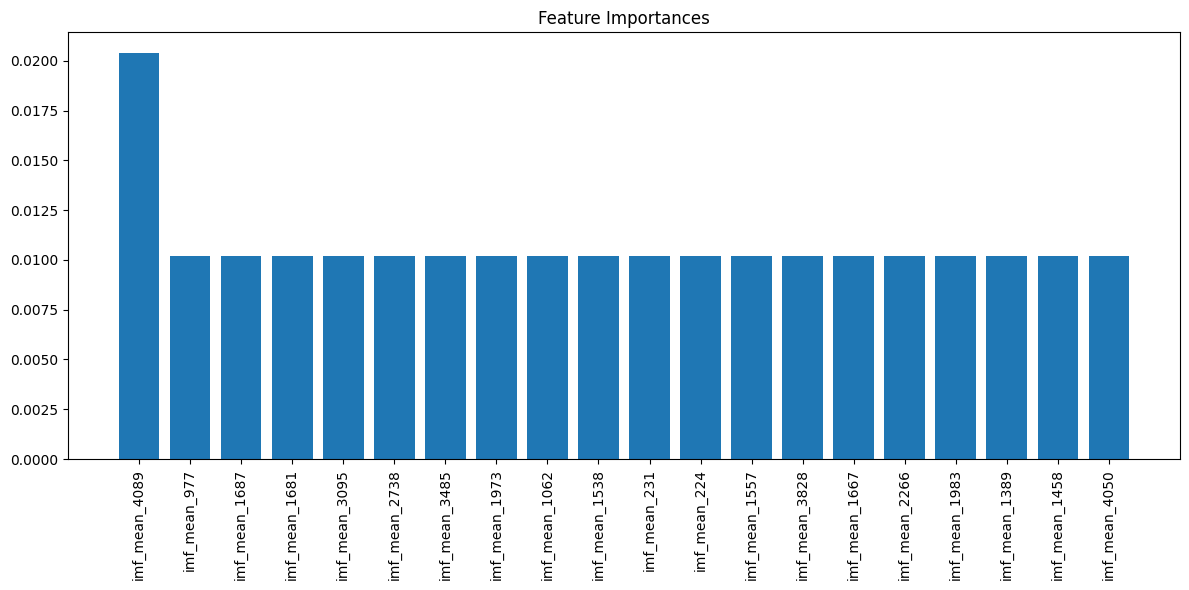

Adjusted weights based on feature importance:
center_frequencies: 0.0081
energy: 0.0081
bandwidth: 0.0081
frequency_spectrum: 0.0081
imfs: 0.8065
load_curve: 0.1613
F load curve shape: (1000, 24, 171)
A load curve shape: (711, 24, 171)


ValueError: operands could not be broadcast together with shapes (24,711) (24,1000) 

In [43]:
import numpy as np
from scipy.stats import pearsonr
from scipy.fft import fft
from sklearn.cluster import KMeans
from dtaidistance import dtw_ndim
from scipy.stats import kurtosis, skew

def calculate_similarity(features1, features2, load_curve1, load_curve2, weights=None):
    if weights is None:
        weights = {
            'dtw': 0.25,
            'pearson': 0.2,
            'fft': 0.15,
            'cluster': 0.2,
            'stats': 0.2
        }
    
    similarity = 0
    
    # 1. DTW距离相似度
    def dtw_similarity(curve1, curve2):
        # 使用dtw_ndim来处理多维数据
        dtw_dist = dtw_ndim.distance(curve1.T, curve2.T)
        max_possible_dtw = dtw_ndim.distance(np.zeros_like(curve1.T), np.ones_like(curve1.T))
        return 1 - dtw_dist / max_possible_dtw  # 归一化并转换为相似度
    
    dtw_sim = dtw_similarity(load_curve1, load_curve2)
    similarity += weights['dtw'] * dtw_sim

    # 2. 皮尔逊相关系数
    def pearson_similarity(curve1, curve2):
        daily_corr = [pearsonr(curve1[:, i], curve2[:, i])[0] for i in range(curve1.shape[1])]
        return np.mean(daily_corr)
    
    pearson_sim = pearson_similarity(load_curve1, load_curve2)
    similarity += weights['pearson'] * ((pearson_sim + 1) / 2)  # 转换到 [0, 1] 范围

    # 3. 基于傅里叶变换的频谱相似度
    def fft_similarity(curve1, curve2):
        fft1 = np.abs(fft(np.mean(curve1, axis=1)))
        fft2 = np.abs(fft(np.mean(curve2, axis=1)))
        return 1 - np.mean(np.abs(fft1 - fft2)) / np.max(fft1)
    
    fft_sim = fft_similarity(load_curve1, load_curve2)
    similarity += weights['fft'] * fft_sim

    # 4. 基于聚类的相似度
    def cluster_similarity(curve1, curve2):
        kmeans1 = KMeans(n_clusters=4, random_state=42).fit(curve1.reshape(curve1.shape[0], -1))
        kmeans2 = KMeans(n_clusters=4, random_state=42).fit(curve2.reshape(curve2.shape[0], -1))
        
        centers1 = kmeans1.cluster_centers_
        centers2 = kmeans2.cluster_centers_
        
        center_sims = [1 - np.mean(np.abs(c1 - c2)) / np.max(c1) for c1, c2 in zip(centers1, centers2)]
        
        dist1 = np.bincount(kmeans1.labels_, minlength=4) / len(kmeans1.labels_)
        dist2 = np.bincount(kmeans2.labels_, minlength=4) / len(kmeans2.labels_)
        dist_sim = 1 - np.sum(np.abs(dist1 - dist2)) / 2
        
        return (np.mean(center_sims) + dist_sim) / 2
    
    cluster_sim = cluster_similarity(load_curve1, load_curve2)
    similarity += weights['cluster'] * cluster_sim

    # 5. 基于统计特征的相似度
    def stats_similarity(curve1, curve2):
        def get_stats(curve):
            return [
                np.mean(curve),
                np.std(curve),
                np.max(curve) / np.mean(curve),  # 峰值因数
                np.mean(curve) / np.max(curve),  # 负载因数
                kurtosis(curve.flatten()),
                skew(curve.flatten())
            ]
        
        stats1 = get_stats(curve1)
        stats2 = get_stats(curve2)
        
        return 1 - np.mean(np.abs((np.array(stats1) - np.array(stats2)) / np.array(stats1)))
    
    stats_sim = stats_similarity(load_curve1, load_curve2)
    similarity += weights['stats'] * stats_sim

    return similarity

def prepare_data(district_features):
    data = []
    labels = []
    feature_names = []
    for district, features in district_features.items():
        feature_vector = []
        for feature_name, feature_value in features.items():
            if isinstance(feature_value, np.ndarray):
                if feature_name == 'imfs':
                    imf_mean = np.mean(feature_value, axis=0)
                    feature_vector.extend(imf_mean)
                    feature_names.extend([f'imf_mean_{i}' for i in range(len(imf_mean))])
                else:
                    feature_vector.extend(feature_value.flatten())
                    feature_names.extend([f'{feature_name}_{i}' for i in range(len(feature_value.flatten()))])
            else:
                feature_vector.append(feature_value)
                feature_names.append(feature_name)
        data.append(feature_vector)
        labels.append(district)
    
    print(f"Number of features: {len(feature_names)}")
    
    # 打印每种特征类型的数量
    feature_types = ['center_frequencies', 'energy', 'bandwidth', 'frequency_spectrum', 'imf']
    for feature_type in feature_types:
        count = sum(1 for name in feature_names if feature_type in name)
        print(f"Number of {feature_type} features: {count}")
    
    return np.array(data), np.array(labels), feature_names

def calculate_feature_importance(X, y, feature_names):
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
    
    # 标准化特征
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train_scaled, y_train)
    
    importances = rf.feature_importances_
    
    # 打印每种特征类型的平均重要性
    feature_types = ['center_frequencies', 'energy', 'bandwidth', 'frequency_spectrum', 'imf']
    for feature_type in feature_types:
        type_importances = [imp for name, imp in zip(feature_names, importances) if feature_type in name]
        if type_importances:
            print(f"Average importance of {feature_type}: {np.mean(type_importances):.6f}")
    
    return importances

def visualize_feature_importance(importances, feature_names):
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(12, 6))
    plt.title("Feature Importances")
    plt.bar(range(min(20, len(importances))), importances[indices][:20])
    plt.xticks(range(min(20, len(importances))), [feature_names[i] for i in indices][:20], rotation=90)
    plt.tight_layout()
    plt.show()

def adjust_weights(importances, feature_names):
    total_importance = np.sum(importances)
    weights = {name: imp / total_importance for name, imp in zip(feature_names, importances)}
    
    combined_weights = {
        'center_frequencies': sum(weights[name] for name in weights if 'center_frequencies' in name),
        'energy': sum(weights[name] for name in weights if 'energy' in name),
        'bandwidth': sum(weights[name] for name in weights if 'bandwidth' in name),
        'frequency_spectrum': sum(weights[name] for name in weights if 'frequency_spectrum' in name),
        'imfs': sum(weights[name] for name in weights if 'imf' in name),
        'load_curve': 0.2  # 保持固定权重
    }
    
    # 确保没有权重为零
    min_weight = 0.01
    for key in combined_weights:
        if combined_weights[key] < min_weight:
            combined_weights[key] = min_weight
    
    # 重新归一化权重
    total_weight = sum(combined_weights.values())
    for key in combined_weights:
        combined_weights[key] /= total_weight
    
    return combined_weights

def main(district_features):
    X, y, feature_names = prepare_data(district_features)
    
    importances = calculate_feature_importance(X, y, feature_names)  # 修复：传递 feature_names
    
    visualize_feature_importance(importances, feature_names)
    
    adjusted_weights = adjust_weights(importances, feature_names)
    
    print("Adjusted weights based on feature importance:")
    for feature, weight in adjusted_weights.items():
        print(f"{feature}: {weight:.4f}")
    
    return adjusted_weights

adjusted_weights = main(district_features)
similarities = {}
f_features = district_features['F']
f_load_curve = np.array(district_user_info['F']['weekload'].tolist())

print("F load curve shape:", f_load_curve.shape)

for district in ['A', 'B', 'C', 'D', 'E']:
    district_load_curve = np.array(district_user_info[district]['weekload'].tolist())
    print(f"{district} load curve shape:", district_load_curve.shape)
    similarities[district] = calculate_similarity(
        district_features[district], 
        f_features,
        district_load_curve,
        f_load_curve
    )

# 输出结果
print("\nUpdated similarities using combined method:")
for district, similarity in similarities.items():
    print(f"{district}: {similarity:.4f}")